## Objective
The goal is to predict customer churn for a bank. The dataset is imbalanced(20% churned and 80% didn't), meaning significantly more non-churners than churners. Our business objective is to:

Identify customers at high risk of churn and make retention efforts.

Avoid spamming loyal customers unnecessarily to maintain trust.

Hence, our primary metric is F1-score (which balances precision and recall).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("Bank_Churn.csv")
df

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


In [3]:
df.shape

(10000, 13)

In [4]:
df.describe()

,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


## Feature Engineering. 

After carefully exploring the dataset, no missing or duplicate values were found. The CustomerID and Surname column was dropped since it holds no predictive value for the churn classification task. During the outlier analysis, it was observed that both Credit Score and Age had significant outliers. However, trimming these values would have resulted in substantial data loss of over 30% for Age and more than 90% for Credit Score and capping them would have distorted their distributions. So both features were binned.  Credit Score was categorized based on the standard FICO Credit Score ranges and Age was binned into labeled age ranges such as '18–25', '26–35', and so on.

In [5]:
df['AgeGroup'] = pd.cut(df['Age'], bins=[18, 25, 35, 45, 60,120], labels=['18-25', '26-35', '36-45', '46-60', '60+'],right=False)
df['CreditScoreCat'] = pd.cut(df['CreditScore'], 
                                   bins=[300, 580, 669, 739, 799, 850], 
                                   labels=['Poor', 'Fair', 'Good', 'Very Good', 'Exceptional'])

In [6]:
new_df = df.drop(columns = ['CustomerId','Surname','CreditScore','Age'])
new_df.head()

,Geography,Gender,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,AgeGroup,CreditScoreCat
0,France,Female,2,0.00,1,1,1,101348.88,1,36-45,Fair
1,Spain,Female,1,83807.86,1,0,1,112542.58,0,36-45,Fair
2,France,Female,8,159660.80,3,1,0,113931.57,1,36-45,Poor
3,France,Female,1,0.00,2,0,0,93826.63,0,36-45,Good
4,Spain,Female,2,125510.82,1,1,1,79084.10,0,36-45,Exceptional


In [22]:
X = new_df.drop(columns = ['Exited'])
y = new_df['Exited']

from sklearn.model_selection import train_test_split, cross_val_score
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=42)

In [17]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
import optuna

In [9]:
transformer = ColumnTransformer(transformers=[
    ('scale', StandardScaler(), [3,7]),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'), [0,1]),
    ('credit_encode', OrdinalEncoder(categories=[['Poor', 'Fair', 'Good', 'Very Good', 'Exceptional']]), [-1]),
    ('age_encode', OrdinalEncoder(categories=[['18-25', '26-35', '36-45', '46-60', '60+']]), [-2])
],remainder='passthrough')

In [10]:
transformer.fit_transform(X_train)
transformer.transform(X_test)

array([[ 0.32993735, -1.01960511,  1.        , ...,  2.        ,
         0.        ,  0.        ],
       [-1.21847056,  0.79888291,  0.        , ...,  2.        ,
         1.        ,  1.        ],
       [-1.21847056, -0.72797953,  0.        , ...,  2.        ,
         1.        ,  0.        ],
       ...,
       [-1.21847056, -1.16591585,  0.        , ...,  1.        ,
         1.        ,  0.        ],
       [-1.21847056, -0.41163463,  0.        , ...,  1.        ,
         1.        ,  0.        ],
       [ 0.62825602,  0.12593183,  1.        , ...,  1.        ,
         1.        ,  1.        ]])

## Model Fitting

To find the best model with the right parameters, I used Optuna with a focus on maximizing the F1 score. The aim was to correctly identify customers likely to churn without wrongly targeting loyal ones. Since the data was imbalanced, I used the Balanced Random Forest Classifier from imblearn, which gave better results than SMOTE. 

In [29]:
def objective(trial):
    classifier_name = trial.suggest_categorical('classifier', ['logistic', 'DecisionTree', 'BalRandomForest'])

    if classifier_name == 'logistic':
        c = trial.suggest_float('c', 0.0001, 100, log=True)
        penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
        solver = 'liblinear' if penalty == 'l1' else 'lbfgs'
        class_weight = trial.suggest_categorical("class_weight", [None, "balanced"])
        model = LogisticRegression(
        C=c,
        penalty=penalty,
        solver=solver,
        class_weight=class_weight,
        max_iter=1000,
        random_state=42
    )

    elif classifier_name == 'DecisionTree':
        max_depth = trial.suggest_int('max_depth', 2, 20)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
        class_weight = trial.suggest_categorical("class_weight", [None, "balanced"])
        model = DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        class_weight=class_weight,
        random_state=42
        )

    elif classifier_name == 'BalRandomForest':
        n_estimators = trial.suggest_int("n_estimators", 30, 200)
        max_depth = trial.suggest_int("max_depth", 5, 20)
        min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
        min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
        max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", 0.5])
        replacement = trial.suggest_categorical("replacement", [True, False])

        model = BalancedRandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        replacement=replacement,
        random_state=42
            )


    pipe = Pipeline([
        ('transformer', transformer),
        ('model', model)
    ])

    score = cross_val_score(pipe, X_train, y_train, cv=5, scoring='f1')
    return score.mean()

In [30]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2025-06-27 22:11:07,483] A new study created in memory with name: no-name-3a02afbd-01fb-4e43-b23c-e734c72fb0e6
[I 2025-06-27 22:11:07,902] Trial 0 finished with value: 0.4943551860838582 and parameters: {'classifier': 'DecisionTree', 'max_depth': 20, 'min_samples_split': 4, 'class_weight': None}. Best is trial 0 with value: 0.4943551860838582.
[I 2025-06-27 22:11:08,232] Trial 1 finished with value: 0.5762833763745208 and parameters: {'classifier': 'DecisionTree', 'max_depth': 8, 'min_samples_split': 3, 'class_weight': 'balanced'}. Best is trial 1 with value: 0.5762833763745208.
[I 2025-06-27 22:11:12,563] Trial 2 finished with value: 0.5973692263605551 and parameters: {'classifier': 'BalRandomForest', 'n_estimators': 109, 'max_depth': 18, 'min_samples_split': 9, 'min_samples_leaf': 6, 'max_features': 0.5, 'replacement': True}. Best is trial 2 with value: 0.5973692263605551.
[I 2025-06-27 22:11:15,657] Trial 3 finished with value: 0.5914653607942061 and parameters: {'classifier': 'B

In [31]:
print("Best F1 Score:", study.best_trial.value)
print("Best Parameters:", study.best_trial.params)

Best F1 Score: 0.6051495743529414
Best Parameters: {'classifier': 'BalRandomForest', 'n_estimators': 162, 'max_depth': 11, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'log2', 'replacement': True}


In [33]:
final_model = BalancedRandomForestClassifier(n_estimators=162,
        max_depth=11,
        min_samples_split=6,
        min_samples_leaf=1,
        max_features= 'log2',                                  
        replacement=True,
        random_state=42)

In [35]:
final_pipe = Pipeline([
    ('transformer', transformer),
    ('model', final_model)
])

In [36]:
final_pipe.fit(X_train, y_train)
y_pred = final_pipe.predict(X_test)

In [37]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.922     0.844     0.881      1607
           1      0.526     0.710     0.605       393

    accuracy                          0.818      2000
   macro avg      0.724     0.777     0.743      2000
weighted avg      0.845     0.818     0.827      2000



The ROC- Curve

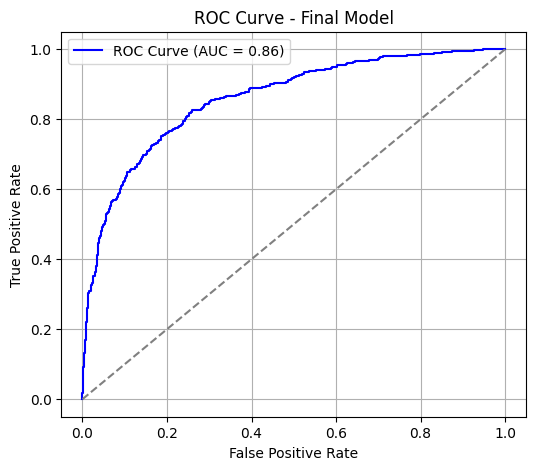

In [38]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

y_probs = final_pipe.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_probs)
auc_score = roc_auc_score(y_test, y_probs)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.2f})", color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Final Model')
plt.legend()
plt.grid()
plt.show()


Balanced Random Forest Classifier achieved an F1 score of 60.5%, accuracy of 81.8%, and ROC AUC of 0.86, making it effective at identifying churners while minimizing false alerts.

In [39]:

# Directly input customer data in order
X_new = pd.DataFrame([[
    'France',         # Geography
    'Female',         # Gender
    5,                # Tenure
    60000,            # Balance
    2,                # NumOfProducts
    1,                # HasCrCard
    0,                # IsActiveMember
    50000,            # EstimatedSalary
    '36-45',          # AgeGroup
    'Fair'            # CreditScoreCat
]], columns=X.columns)  # Use the same column order as training data

# Predict
prediction = final_pipe.predict(X_new)
probability = final_pipe.predict_proba(X_new)[0][1]

print("Prediction:", "Churn" if prediction[0] == 1 else "No Churn")
print("Churn Probability:", round(probability, 3))


Prediction: No Churn
Churn Probability: 0.365
